# 08 线性回归
线性模型可以看做是单层的神经网络
### 衡量预估质量
比较真实值和预估值
平方损失=(真实值-预估值)^2/2
训练数据通常越多越好
### 参数学习
损失函数：用来评价模型的预测值和真实值不一样的程度
通过最小化损失来学习参数

### 基础优化方法
- 梯度下降
  - 挑选一个初始值$w_0$
  - 重复迭代
    - 沿梯度方向将增加损失函数值
    - 学习率：步长的超参数(需要人为指定)
      - 步长太小会下降太慢，计算参数非常expensive，步长太小会增加资源消耗
      - 步长太大会震荡，没有一直在下降
    - 实际上我们使用小批量梯度下降
      - 梯度下降里面，要计算梯度要对整个损失函数求导，损失函数是对所有样本的平均损失，意味着要对所有样本整个计算一遍，往往需要数分钟到数个小时
      - 我们可以随机采样b个样本来计算近似损失
      - b是批量大小，另一个重要的超参数
        - 批量太小：每次计算量太小，不适合并行来最大利用计算资源
        - 批量太大：内存消耗增加，浪费计算


### 线性回归从零开始实现
包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [12]:
# 导入包
%matplotlib inline
import random
import torch
from d2l import torch as d2l


In [13]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + noise"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [14]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.7070,  0.8781]) 
label: tensor([-0.2009])


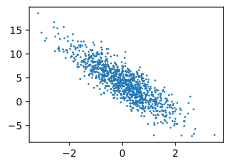

In [15]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)

In [16]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)# 将下标完全打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices] # yield表示返回值后继续执行这个函数

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.6136, -0.7562],
        [-1.2233, -1.2113],
        [-2.0393,  0.5974],
        [ 0.1806,  0.4054],
        [ 0.5510,  0.7525],
        [ 0.5368, -0.2440],
        [-1.2704,  2.6234],
        [ 0.4285, -2.5266],
        [ 1.8935,  0.5569],
        [-2.0922, -0.1922]]) 
 tensor([[10.0033],
        [ 5.8671],
        [-1.9059],
        [ 3.1638],
        [ 2.7469],
        [ 6.1124],
        [-7.2437],
        [13.6529],
        [ 6.0798],
        [ 0.6584]])


In [17]:
# 定义参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [18]:
# 定义模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [19]:
# 定义损失函数 : 均方损失
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2# 除以2方便求导

In [20]:
# 定义优化算法 ：小批量随机梯度下降
def sgd(params, lr, batch_size):
    # lr: learning rate
    with torch.no_grad(): #不需要计算梯度
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [21]:
# 训练过程
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)# net的预测值与真实值y计算损失
        l.sum().backward()# 求和之后算梯度
        sgd([w, b], lr, batch_size)# 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.049564
epoch 2, loss 0.000207
epoch 3, loss 0.000050


In [22]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 8.5115e-05, -3.3402e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


### 线性回归的简洁实现

In [23]:
%reset
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

Nothing done.


In [24]:
def load_array(data_arrays, batch_size, is_train=True):  # @save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


batch_size = 10
data_iter = load_array((features, labels), batch_size)


In [25]:
next(iter(data_iter))

[tensor([[ 0.9207, -2.3258],
         [ 0.0888,  1.2987],
         [ 1.3609,  1.3276],
         [-0.4818, -0.3959],
         [ 1.8101,  0.5489],
         [-1.2081, -0.3054],
         [-1.6203,  0.0699],
         [-0.6663,  1.3155],
         [ 0.3772,  1.5831],
         [-0.2538,  0.4931]]),
 tensor([[13.9398],
         [-0.0186],
         [ 2.4146],
         [ 4.5864],
         [ 5.9467],
         [ 2.8249],
         [ 0.7250],
         [-1.6123],
         [-0.4147],
         [ 2.0117]])]

In [26]:
# nn是神经网络的缩写
from torch import nn
# Sequential 把线性函数放到一个list of layers
net = nn.Sequential(nn.Linear(2, 1))  # Linear参数 输入维度和输出维度。

In [27]:
net[0].weight.data.normal_(0, 0.01)  # weight权重
net[0].bias.data.fill_(0)  # bias偏差


tensor([0.])

In [28]:
loss = nn.MSELoss()  # 平方范数


In [29]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)


In [30]:
num_epochs = 3  # 迭代三个周期
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()  # 求梯度
        trainer.step()  # 模型更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')


epoch 1, loss 0.000249
epoch 2, loss 0.000101
epoch 3, loss 0.000100


In [31]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 6.3062e-05, -7.2718e-05])
b的估计误差： tensor([-0.0007])
